In [2]:
!pip install chembl_webresource_client rdkit pandas

In [4]:
from chembl_webresource_client.new_client import new_client
import pandas as pd

# 1. Search for approved drugs
molecule = new_client.molecule
approved_drugs = molecule.filter(max_phase=4).only(['molecule_chembl_id', 'molecule_structures', 'molecule_properties'])

# 2. Extract relevant fields
data = []
for drug in approved_drugs:
    try:
        chembl_id = drug['molecule_chembl_id']
        smiles = drug['molecule_structures']['canonical_smiles']
        props = drug['molecule_properties']
        mol_wt = props['full_mwt']
        logp = props['alogp']
        hbd = props['hba']
        hba = props['hbd']
        data.append([chembl_id, smiles, mol_wt, logp, hbd, hba])
    except:
        continue

# 3. Create a DataFrame
columns = ['chembl_id', 'smiles', 'mol_weight', 'logp', 'hbd', 'hba']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv("chembl_druglike_molecules.csv", index=False)

print("✅ Fetched", len(df), "molecules")

✅ Fetched 3594 molecules


In [5]:
!pip install rdkit

In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Load your ChEMBL dataset
df = pd.read_csv("chembl_druglike_molecules.csv")

# Function to compute additional molecular features
def compute_rdkit_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        tpsa = Descriptors.TPSA(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        heavy_atoms = Descriptors.HeavyAtomCount(mol)
        return pd.Series([tpsa, rot_bonds, heavy_atoms])
    except:
        return pd.Series([None, None, None])

# Apply feature computation
df[['tpsa', 'rotatable_bonds', 'heavy_atoms']] = df['smiles'].apply(compute_rdkit_features)

# Save the enhanced dataset
df.to_csv("chembl_druglike_features_extended.csv", index=False)

print("✅ Dataset enhanced with RDKit features.")

[11:05:23] WARNING: not removing hydrogen atom without neighbors
[11:05:23] WARNING: not removing hydrogen atom without neighbors
[11:05:23] WARNING: not removing hydrogen atom without neighbors
[11:05:23] WARNING: not removing hydrogen atom without neighbors
[11:05:23] WARNING: not removing hydrogen atom without neighbors
[11:05:23] WARNING: not removing hydrogen atom without neighbors


✅ Dataset enhanced with RDKit features.


In [7]:
import pandas as pd

# Load the dataset we enhanced earlier
df = pd.read_csv("chembl_druglike_features_extended.csv")

# Add a binary label
df["drug_like"] = 1

# Save the labeled dataset
df.to_csv("chembl_druglike_labeled.csv", index=False)

print("✅ All approved drugs labeled as drug_like = 1.")


✅ All approved drugs labeled as drug_like = 1.


In [9]:
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import time
import random

def get_smiles_from_pubchem(cid):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/JSON"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()
            return data["PropertyTable"]["Properties"][0]["CanonicalSMILES"]
    except:
        return None

def violates_lipinski(mol):
    try:
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        violations = 0
        if mw > 500: violations += 1
        if logp > 5: violations += 1
        if hbd > 5: violations += 1
        if hba > 10: violations += 1
        return violations >= 2
    except:
        return False

non_drug_data = []
attempts = 0
max_samples = 1000  # You can increase to 5000 later

print("⏳ Fetching from PubChem API...")

while len(non_drug_data) < max_samples and attempts < 5000:
    cid = random.randint(1_000_000, 10_000_000)
    smiles = get_smiles_from_pubchem(cid)
    if not smiles:
        attempts += 1
        continue
    mol = Chem.MolFromSmiles(smiles)
    if mol and violates_lipinski(mol):
        try:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            tpsa = Descriptors.TPSA(mol)
            rot_bonds = Descriptors.NumRotatableBonds(mol)
            heavy_atoms = Descriptors.HeavyAtomCount(mol)
            non_drug_data.append([smiles, mw, logp, hbd, hba, tpsa, rot_bonds, heavy_atoms])
        except:
            pass
    attempts += 1
    time.sleep(0.1)  # Respect API limits

print(f"✅ Collected {len(non_drug_data)} non-drug-like molecules.")

# Save to CSV
columns = ["smiles", "mol_weight", "logp", "hbd", "hba", "tpsa", "rotatable_bonds", "heavy_atoms"]
df_non_drugs = pd.DataFrame(non_drug_data, columns=columns)
df_non_drugs["drug_like"] = 0
df_non_drugs.to_csv("non_druglike_labeled.csv", index=False)
print("📁 Saved to 'non_druglike_labeled.csv'")


⏳ Fetching from PubChem API...
✅ Collected 428 non-drug-like molecules.
📁 Saved to 'non_druglike_labeled.csv'


In [10]:
import pandas as pd
from sklearn.utils import shuffle

# Load both datasets
df_drugs = pd.read_csv("chembl_druglike_labeled.csv")
df_nondrugs = pd.read_csv("non_druglike_labeled.csv")

# Ensure same columns
common_cols = list(set(df_drugs.columns) & set(df_nondrugs.columns))
df_drugs = df_drugs[common_cols]
df_nondrugs = df_nondrugs[common_cols]

# Merge and shuffle
df_full = pd.concat([df_drugs, df_nondrugs], ignore_index=True)
df_full = shuffle(df_full, random_state=42)

# Save final dataset
df_full.to_csv("druglikeness_dataset_final.csv", index=False)

print(f"✅ Final dataset ready with {df_full.shape[0]} samples.")
print(df_full["drug_like"].value_counts())


✅ Final dataset ready with 4022 samples.
drug_like
1    3594
0     428
Name: count, dtype: int64


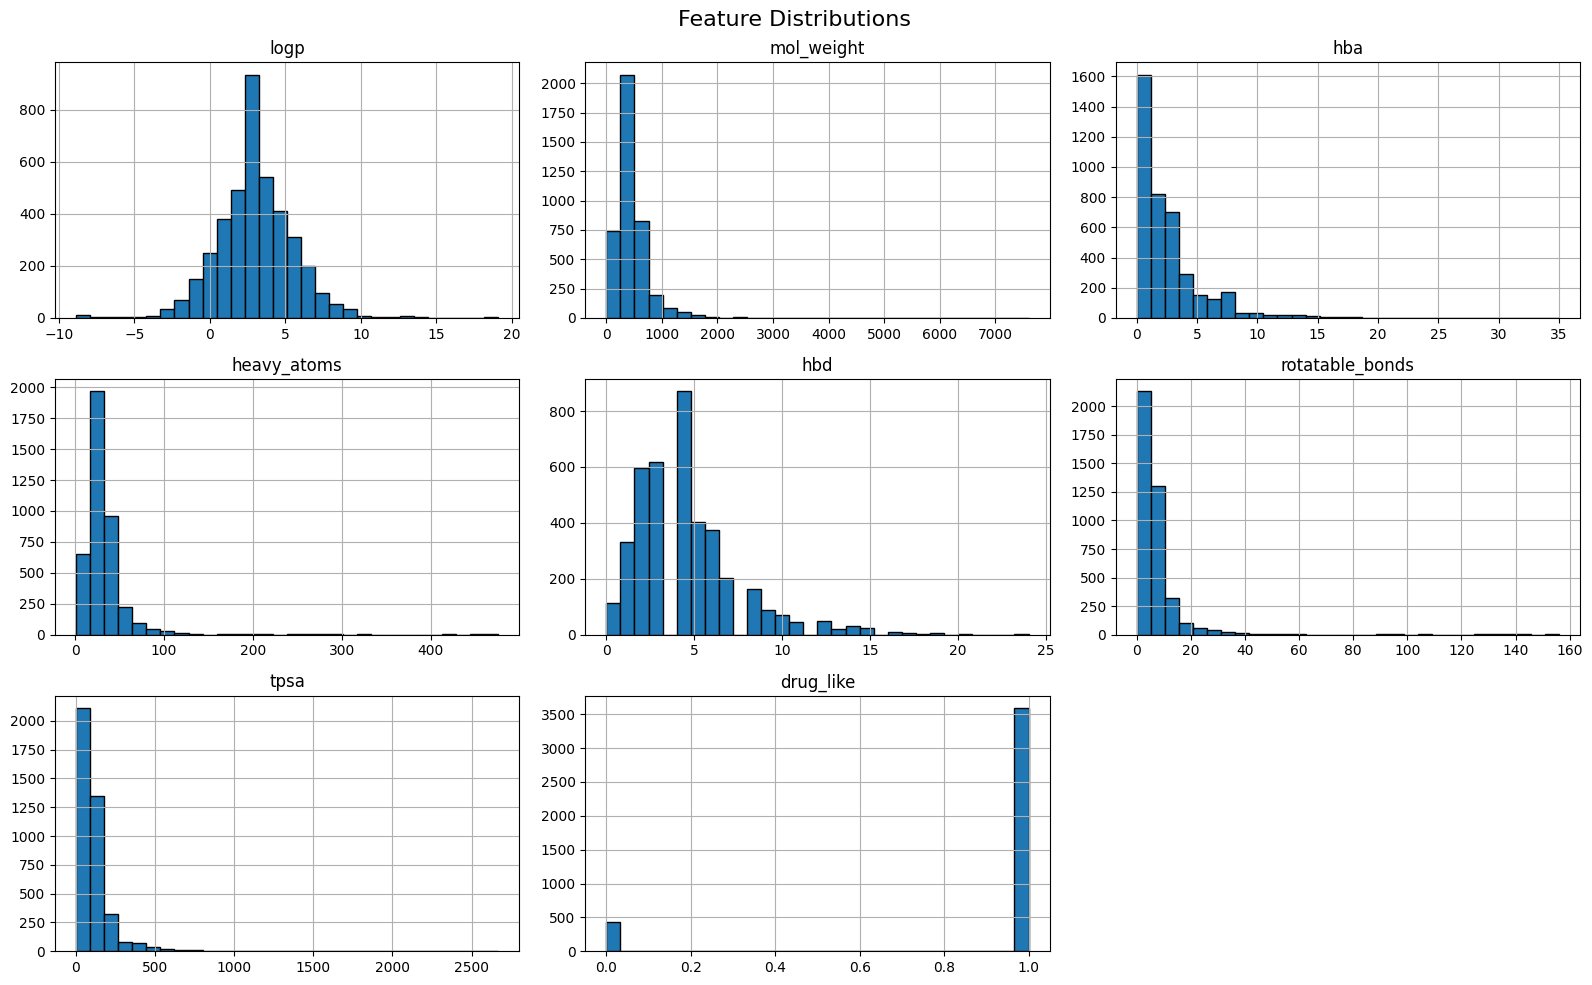

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv("druglikeness_dataset_final.csv")

# Drop non-numeric columns for analysis
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Fill missing values with column means
numeric_df = numeric_df.fillna(numeric_df.mean())

# 📊 Histograms
numeric_df.hist(bins=30, figsize=(16, 10), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

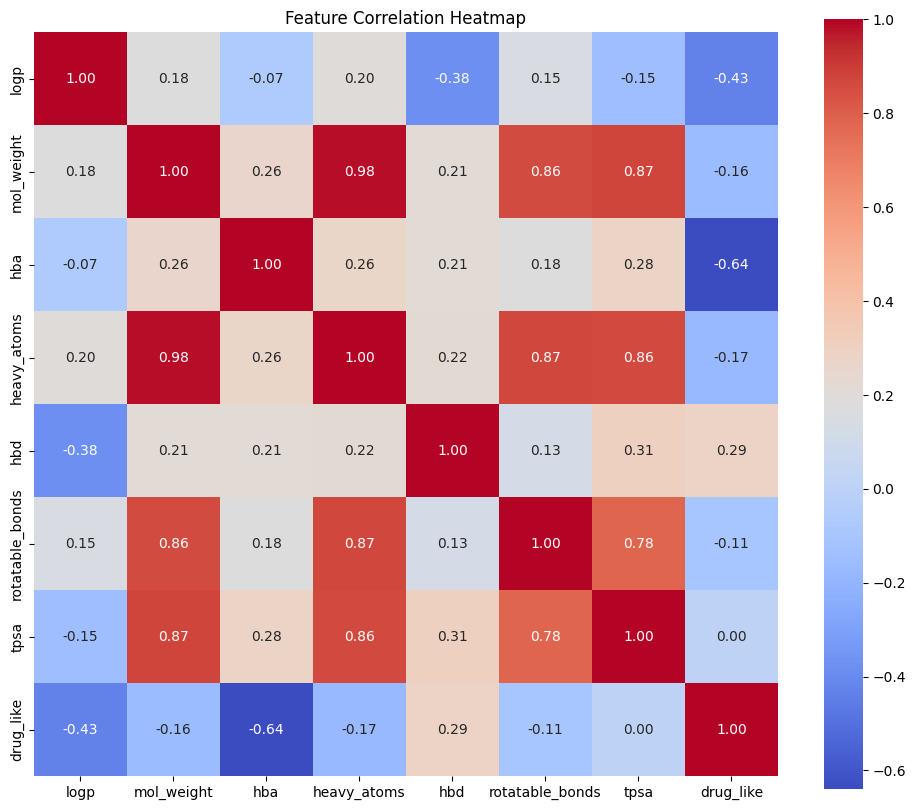

In [35]:
# 📈 Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

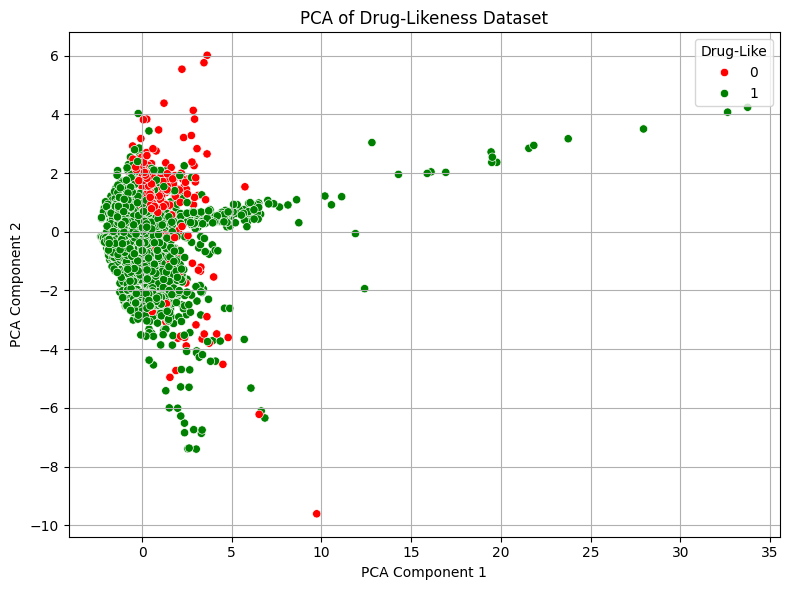

In [36]:
# 📉 PCA
X = numeric_df.drop("drug_like", axis=1)
y = numeric_df["drug_like"]

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["red", "green"])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Drug-Likeness Dataset")
plt.legend(title="Drug-Like")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv("druglikeness_dataset_final.csv")

# Drop SMILES if present (not used in traditional ML)
if "smiles" in df.columns:
    df = df.drop(columns=["smiles"])

# Separate features and target
X = df.drop(columns=["drug_like"])
y = df["drug_like"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.9900621118012423

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95        82
           1       0.99      1.00      0.99       723

    accuracy                           0.99       805
   macro avg       0.99      0.96      0.97       805
weighted avg       0.99      0.99      0.99       805



In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Rename for comparison
y_pred_rf = y_pred
y_proba_rf = clf.predict_proba(X_test)[:, 1]

# Metrics for Random Forest
metrics_rf = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1 Score": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_proba_rf)
}

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        82
           1       1.00      1.00      1.00       723

    accuracy                           1.00       805
   macro avg       1.00      0.98      0.99       805
weighted avg       1.00      1.00      1.00       805



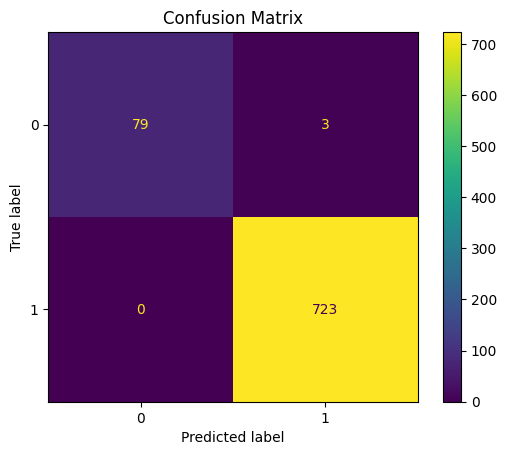

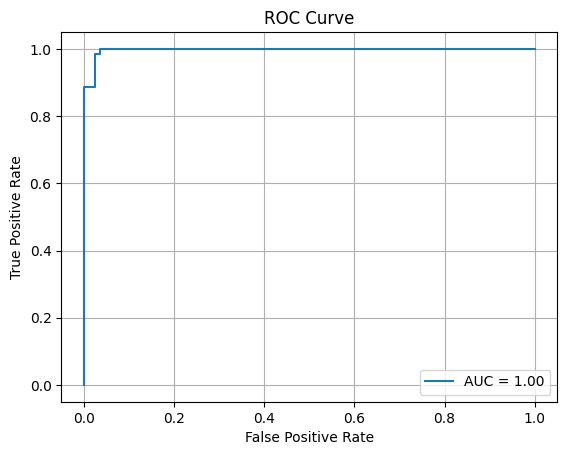

In [43]:
# 🧪 Evaluation for Traditional ML Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_proba = clf.predict_proba(X_test)[:, 1]

print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-12-6bf6844ea02c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
<ipython-input-12-6bf6844ea02c>:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


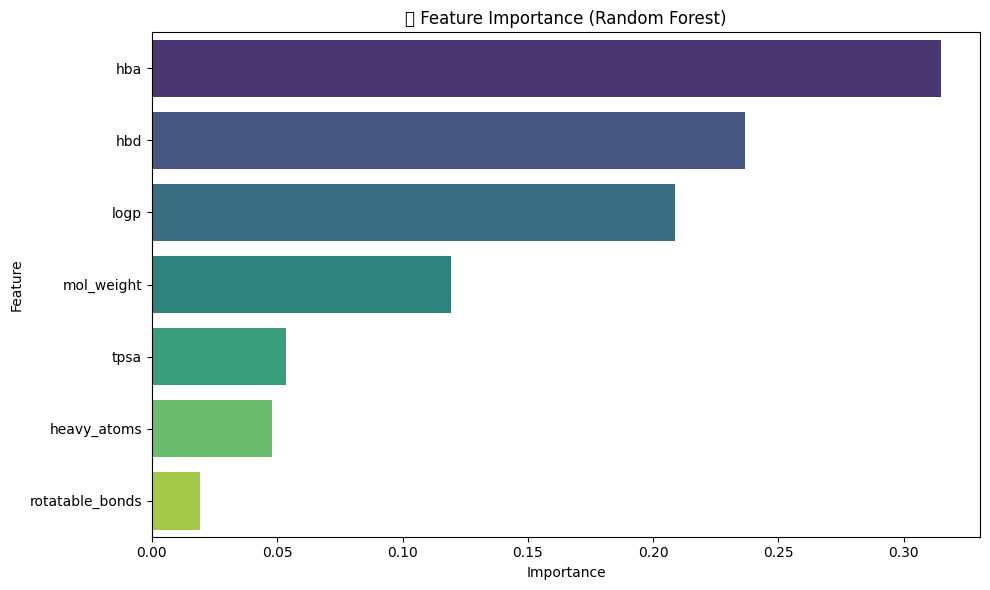

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
plt.title("🔍 Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


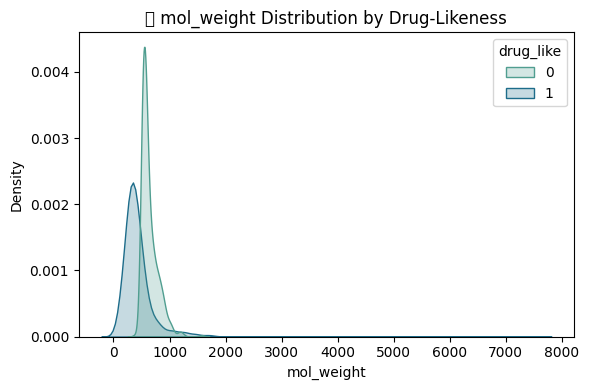

<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


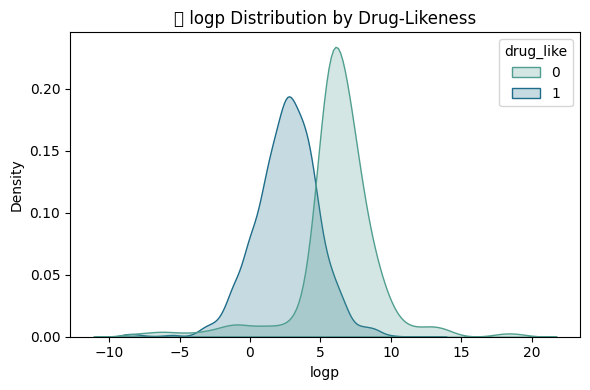

<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


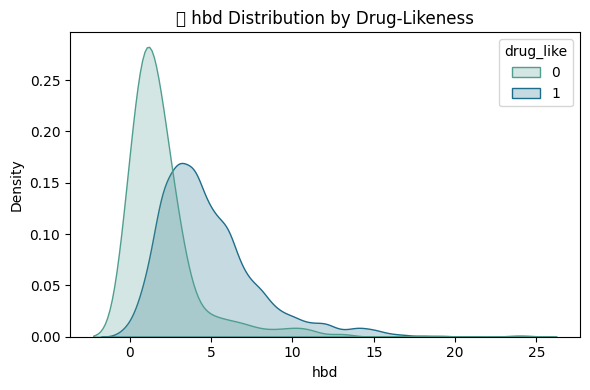

<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


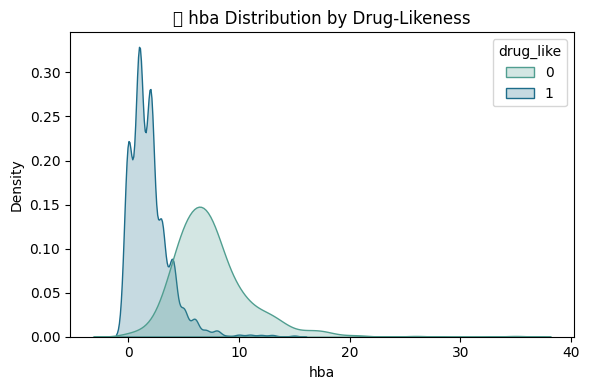

<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


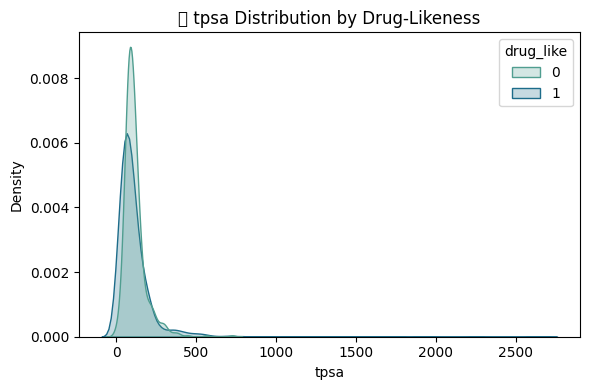

<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


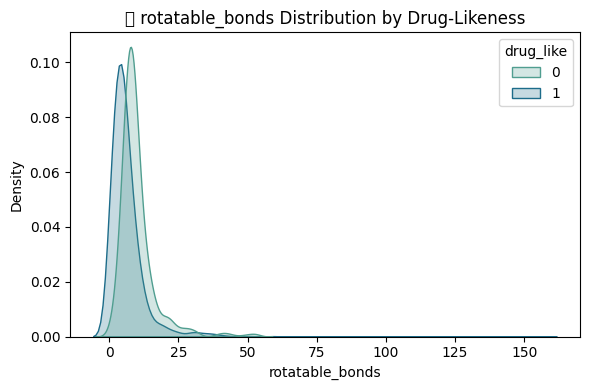

<ipython-input-13-d06a6534f5b0>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


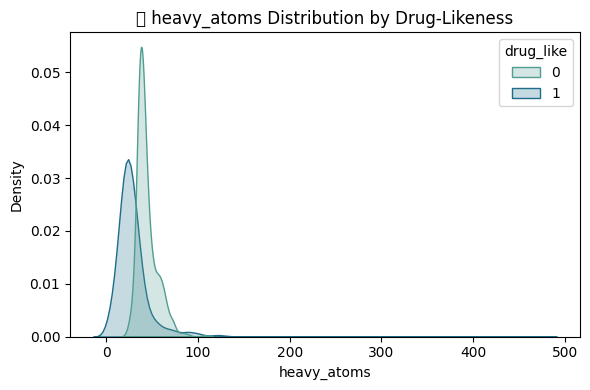

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reload data (in case you're in a fresh session)
df = pd.read_csv("druglikeness_dataset_final.csv")

# Plot distributions
features = ["mol_weight", "logp", "hbd", "hba", "tpsa", "rotatable_bonds", "heavy_atoms"]

for feat in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=feat, hue="drug_like", fill=True, common_norm=False, palette="crest")
    plt.title(f"📈 {feat} Distribution by Drug-Likeness")
    plt.tight_layout()
    plt.show()


<ipython-input-14-55dbeee8e6bf>:9: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


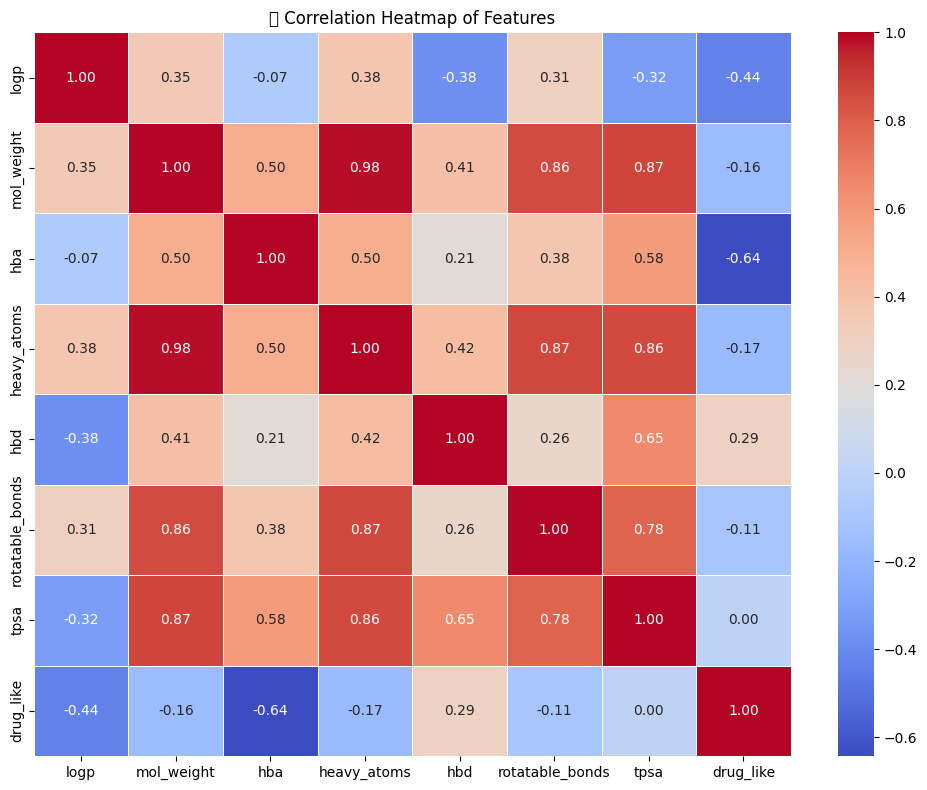

In [14]:
# Drop SMILES if exists
if "smiles" in df.columns:
    df = df.drop(columns=["smiles"])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🧪 Correlation Heatmap of Features")
plt.tight_layout()
plt.show()


<ipython-input-16-b3514e02a104>:36: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


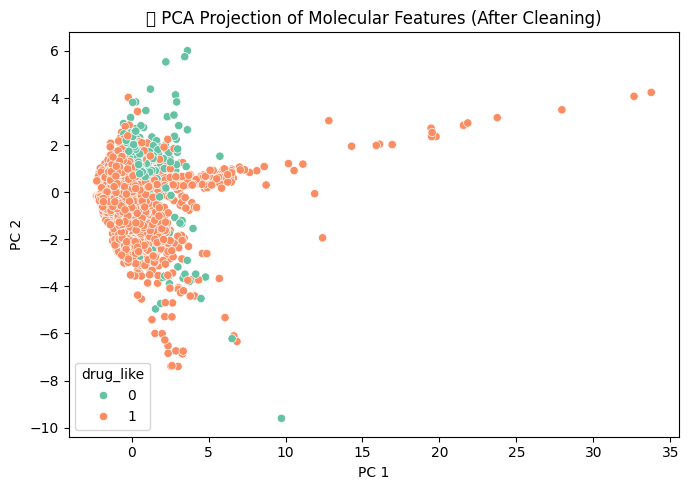

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Reload dataset
df = pd.read_csv("druglikeness_dataset_final.csv")

# Drop SMILES if present
if "smiles" in df.columns:
    df = df.drop(columns=["smiles"])

# Separate features and labels
X = df.drop(columns=["drug_like"])
y = df["drug_like"]

# Fill missing values with column mean
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set2")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("🌐 PCA Projection of Molecular Features (After Cleaning)")
plt.tight_layout()
plt.show()

In [17]:
!pip install transformers
!pip install datasets
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [18]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from tqdm import tqdm

# Load model + tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model.eval()  # Inference mode

# Load dataset
df = pd.read_csv("druglikeness_dataset_final.csv")

# Keep only SMILES and label
smiles_list = df["smiles"].tolist()
labels = df["drug_like"].tolist()

# Tokenize + embed SMILES
def get_chemberta_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Use [CLS] token

# Generate embeddings
embeddings = []
for sm in tqdm(smiles_list, desc="Embedding SMILES"):
    try:
        emb = get_chemberta_embedding(sm)
        embeddings.append(emb)
    except:
        embeddings.append(None)

# Drop failed samples
valid_idx = [i for i, e in enumerate(embeddings) if e is not None]
X = [embeddings[i] for i in valid_idx]
y = [labels[i] for i in valid_idx]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Embedding SMILES:   0%|          | 1/4022 [00:00<10:43,  6.25it/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Embedding SMILES: 100%|██████████| 4022/4022 [08:01<00:00,  8.36it/s]


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9950310559006211

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98        82
           1       1.00      1.00      1.00       723

    accuracy                           1.00       805
   macro avg       0.99      0.98      0.99       805
weighted avg       1.00      1.00      1.00       805



<ipython-input-20-6c8623dacf58>:15: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


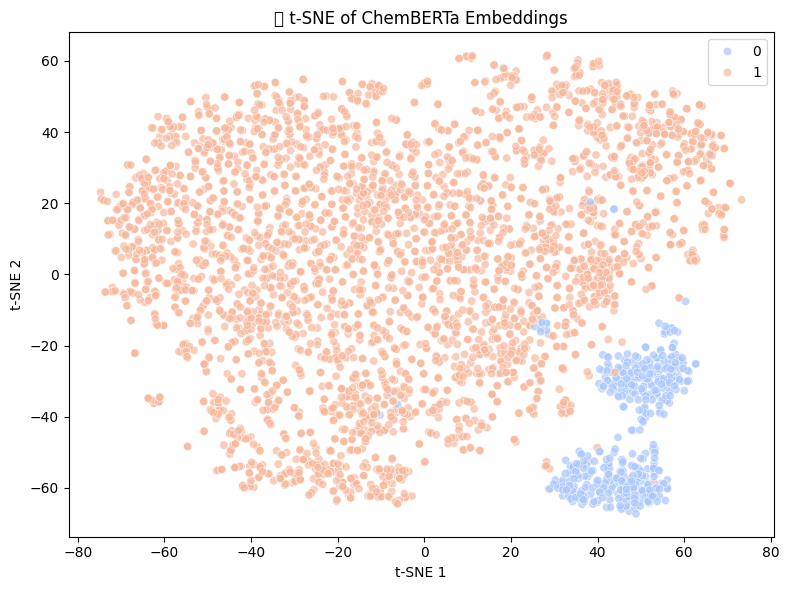

In [20]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Run t-SNE (dimensionality reduction to 2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("🌐 t-SNE of ChemBERTa Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

In [21]:
from sklearn.neural_network import MLPClassifier

# Define and train the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(256, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred_mlp = mlp.predict(X_test)

print("✅ MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("\n📊 MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))

✅ MLP Accuracy: 0.9950310559006211

📊 MLP Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98        82
           1       1.00      1.00      1.00       723

    accuracy                           1.00       805
   macro avg       0.99      0.98      0.99       805
weighted avg       1.00      1.00      1.00       805



In [23]:
!pip install transformers datasets

In [25]:
from transformers import AutoTokenizer
from datasets import Dataset
import pandas as pd
import numpy as np

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)
smiles_array = np.array([smiles_list[i] for i in valid_idx])  # keep SMILES aligned with valid embeddings

# Split everything at once
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    X, y, smiles_array, test_size=0.2, random_state=42
)

# Prepare Hugging Face DataFrames
df_train = pd.DataFrame({
    "text": smiles_train,
    "label": y_train
})

df_test = pd.DataFrame({
    "text": smiles_test,
    "label": y_test
})

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(df_test).map(tokenize, batched=True)

# Set correct format for PyTorch usage
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Hugging Face Datasets are ready for fine-tuning.")


Map:   0%|          | 0/3217 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

✅ Hugging Face Datasets are ready for fine-tuning.


In [27]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import os

# 🛑 Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load ChemBERTa model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    "seyonec/ChemBERTa-zinc-base-v1",
    num_labels=2
)

# Training settings
training_args = TrainingArguments(
    output_dir="./chemberta_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",               # ✅ new parameter (replaces deprecated one)
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to=[],                        # ✅ disables all loggers (wandb, tensorboard, etc.)
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 🚀 Train the model
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.000700,0.032158
2,0.020600,0.024194
3,0.000100,0.033406


TrainOutput(global_step=606, training_loss=0.011312838162231357, metrics={'train_runtime': 6989.7312, 'train_samples_per_second': 1.381, 'train_steps_per_second': 0.087, 'total_flos': 319610716107264.0, 'train_loss': 0.011312838162231357, 'epoch': 3.0})

In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)

# Predicted class labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Evaluation metrics
print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("✅ F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

✅ Accuracy: 0.9962732919254659
✅ F1 Score: 0.9979296066252588

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        82
           1       1.00      1.00      1.00       723

    accuracy                           1.00       805
   macro avg       1.00      0.98      0.99       805
weighted avg       1.00      1.00      1.00       805


Confusion Matrix:
 [[ 79   3]
 [  0 723]]


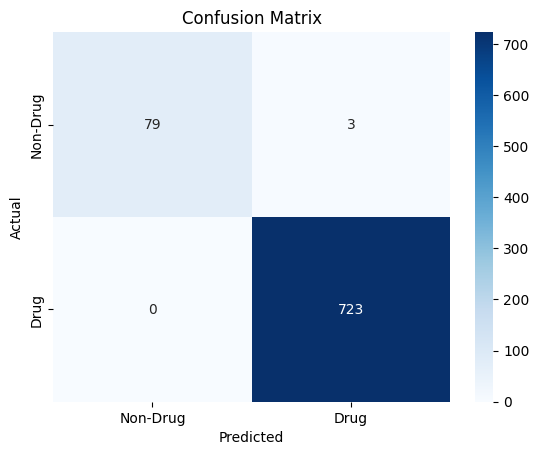

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Drug", "Drug"], yticklabels=["Non-Drug", "Drug"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Save the model and tokenizer
model.save_pretrained("drug_likeness_model")
tokenizer.save_pretrained("drug_likeness_model")

print("✅ Model and tokenizer saved in 'drug_likeness_model/' folder.")

✅ Model and tokenizer saved in 'drug_likeness_model/' folder.


In [45]:
import joblib

# Save the trained model
joblib.dump(clf, "random_forest_model.pkl")

print("✅ Random Forest model saved as random_forest_model.pkl")

✅ Random Forest model saved as random_forest_model.pkl


In [49]:
import numpy as np
from scipy.special import softmax

# Run prediction using ChemBERTa
preds = trainer.predict(test_dataset)

y_pred_bert = np.argmax(preds.predictions, axis=1)
y_proba_bert = softmax(preds.predictions, axis=1)[:, 1]

# Metrics for ChemBERTa
metrics_bert = {
    "Accuracy": accuracy_score(y_test, y_pred_bert),
    "Precision": precision_score(y_test, y_pred_bert),
    "Recall": recall_score(y_test, y_pred_bert),
    "F1 Score": f1_score(y_test, y_pred_bert),
    "ROC AUC": roc_auc_score(y_test, y_proba_bert)
}


In [50]:
# 📊 Model Comparison Table
comparison_df = pd.DataFrame({
    "Random Forest": metrics_rf,
    "ChemBERTa": metrics_bert
})
print("🔬 Model Performance Comparison:")
display(comparison_df.round(4))

🔬 Model Performance Comparison:


,Random Forest,ChemBERTa
Accuracy,0.9963,0.9963
Precision,0.9959,0.9959
Recall,1.0000,1.0000
F1 Score,0.9979,0.9979
ROC-AUC,0.9969,NaN
ROC AUC,NaN,0.9992


<Figure size 1000x600 with 0 Axes>

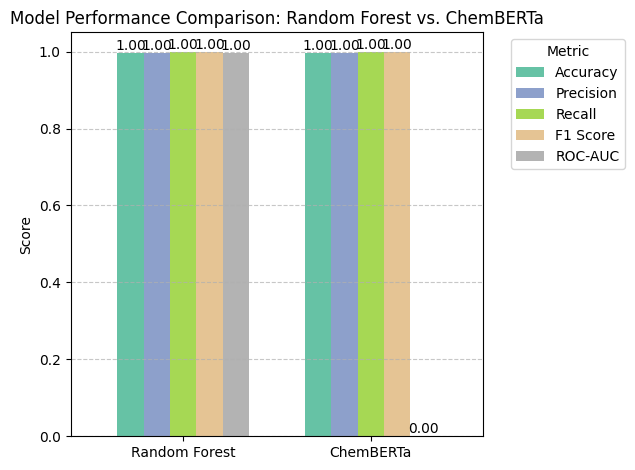

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop duplicates or fix the label if any
comparison_df_clean = comparison_df.copy()
if "ROC AUC" in comparison_df_clean.index and "ROC-AUC" in comparison_df_clean.index:
    comparison_df_clean = comparison_df_clean.drop(index="ROC AUC")

# Transpose so metrics are on x-axis
comparison_df_clean = comparison_df_clean.T

# Plot improved grouped bar chart
plt.figure(figsize=(10, 6))
comparison_df_clean.plot(kind='bar', width=0.7, colormap='Set2')
plt.title("Model Performance Comparison: Random Forest vs. ChemBERTa")
plt.ylabel("Score")
plt.ylim(0.0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge')

plt.show()


In [53]:
!zip -r /content/project_backup.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.04.07/ (stored 0%)
  adding: content/.config/logs/2025.04.07/13.42.24.146310.log (deflated 58%)
  adding: content/.config/logs/2025.04.07/13.42.34.302585.log (deflated 58%)
  adding: content/.config/logs/2025.04.07/13.42.43.503346.log (deflated 57%)
  adding: content/.config/logs/2025.04.07/13.42.44.251076.log (deflated 56%)
  adding: content/.config/logs/2025.04.07/13.42.02.070730.log (deflated 92%)
  adding: content/.config/logs/2025.04.07/13.42.32.824024.log (deflated 86%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (sto

In [54]:
from google.colab import files
files.download('/content/project_backup.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>